In [168]:
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm, kstest, truncnorm
from collections import Counter

In [169]:
product_list = pd.read_excel('shipment_stochastic.xlsx', engine = 'openpyxl')
product_codes = product_list['Code'].tolist()

In [170]:
db_config = {'user': 'XXXXXX','password': 'XXXXXX','host': 'XXXXXX','port': '5432', 'database': 'XXXXXX'}
engine = create_engine(f"postgresql+psycopg2://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}")
query = f"""
    SELECT imtrn.xitem, caitem.xdesc,imtrn.xyear, imtrn.xper, imtrn.xqty, imtrn.xval, opddt.xlineamt, imtrn.xdocnum
    FROM imtrn 
    JOIN caitem
    ON imtrn.xitem = caitem.xitem
    JOIN opddt
    ON imtrn.xdocnum = opddt.xdornum AND imtrn.xitem = opddt.xcode
    WHERE imtrn.zid = 100001
    AND caitem.zid = 100001
    AND opddt.zid = 100001
    AND imtrn.xitem IN %(product_codes)s
    """
sales_data = pd.read_sql(query, con=engine, params={"product_codes": tuple(product_codes)})

In [171]:
month_sales_df = sales_data.groupby(['xitem', 'xdesc', 'xyear', 'xper']).agg({
        'xqty': 'sum',
        'xval': 'sum',
        'xlineamt': 'sum'}).reset_index()

In [172]:
month_sales_df['Profit'] = month_sales_df['xlineamt'] - month_sales_df['xval']
month_sales_df['Profit/unit'] = month_sales_df['Profit']/month_sales_df['xqty']
month_sales_df = month_sales_df[month_sales_df['Profit'] > 0]
month_sales_df = month_sales_df[month_sales_df['xyear'] > 2020]

In [173]:
#create a distribution type table for all the products within the monthly sales data. using ks-test and p values
#need to investigate the shape, location and scale of lognormal and see why the random generations are relegated to the upper threshold
# Done separately to verify distribution type
grouped = month_sales_df.groupby('xitem')
distribution_summary = []

for product_code, product_data in grouped:
    
    #Demand or quantity sold distribution for all the months for this product within the sales data
    demand_mean, demand_std = norm.fit(product_data['xqty'])
    ks_stat_normal, p_value_normal = kstest(product_data['xqty'], 'norm', args=(demand_mean, demand_std))

    log_shape, log_loc, log_scale = lognorm.fit(product_data['xqty'], floc=0)
    ks_stat_lognorm, p_value_lognorm = kstest(product_data['xqty'], 'lognorm', args=(log_shape, log_loc, log_scale))

    if p_value_normal > 0.05:
        best_fit_demand = 'Normal'
    elif p_value_lognorm > 0.05:
        best_fit_demand = 'Lognormal'
    else:
        best_fit_demand = 'Empirical'

    profitr_mean, profitr_std = norm.fit(product_data['Profit/unit'])
    ks_stat_normal_profitr, p_value_normal_profitr = kstest(product_data['Profit/unit'], 'norm', args=(profitr_mean, profitr_std))

    log_shape_profitr, log_loc_profitr, log_scale_profitr = lognorm.fit(product_data['Profit/unit'], floc=0)
    ks_stat_lognorm_profitr, p_value_lognorm_profitr = kstest(product_data['Profit/unit'], 'lognorm', args=(log_shape_profitr, log_loc_profitr, log_scale_profitr))

    if p_value_normal_profitr > 0.05:
        best_fit_profit = 'Normal'
    elif p_value_lognorm_profitr > 0.05:
        best_fit_profit = 'Lognormal'
    else:
        best_fit_profit = 'Empirical'

    distribution_summary.append({
        'xitem': product_code,
        'Demand_Distribution': best_fit_demand,
        'Profit_Ratio_Distribution': best_fit_profit
    })

distribution_summary_df = pd.DataFrame(distribution_summary)

In [174]:
#Take the distribution type from the previously created dataframe and 
#create scenarios with given probabilities based on the distribution type
num_scenarios = 3
num_bins = 10
scenarios_list = []

for index, row in distribution_summary_df.iterrows():
    product_code = row['xitem']
    demand_dist = row['Demand_Distribution']
    profit_dist = row['Profit_Ratio_Distribution']
    product_data = month_sales_df[month_sales_df['xitem'] == product_code]
    
    #For demand scenarios
    if demand_dist == 'Normal':
        demand_mean, demand_std = norm.fit(product_data['xqty'])
        lower, upper = 0, product_data['xqty'].max()
        a, b = (lower - demand_mean)/ demand_std, (upper - demand_mean) / demand_std
        demand_scenarios = truncnorm.rvs(a, b, loc=demand_mean, scale=demand_std, size=num_scenarios)
        demand_probabilities = norm.pdf(demand_scenarios, demand_mean, demand_std)
        demand_probabilities /= demand_probabilities.sum()
    else: #lognormal and empirical
        demand_bins = pd.cut(product_data['xqty'],bins=num_bins)
        bin_counts = demand_bins.value_counts()
        bin_probabilities = bin_counts / bin_counts.sum()
        bin_intervals = bin_probabilities.index
        
        demand_scenarios = []
        demand_probabilities = []
        for _ in range(num_scenarios):
            chosen_bin = np.random.choice(bin_intervals, p=bin_probabilities)
            demand_scenarios.append(np.random.uniform(chosen_bin.left, chosen_bin.right))
            demand_probabilities.append(bin_probabilities[chosen_bin])
        
        demand_probabilities = np.array(demand_probabilities)
        demand_probabilities /= demand_probabilities.sum()
        
    # For profit ratio scenarios
    if profit_dist == 'Normal':
        profit_mean, profit_std = norm.fit(product_data['Profit/unit'])
        lower, upper = 0, product_data['Profit/unit'].max()
        a, b = (lower - profit_mean)/ profit_std, (upper - profit_mean) / profit_std
        profitr_scenarios = truncnorm.rvs(a, b, loc=profit_mean, scale=profit_std, size=num_scenarios)
        profit_probabilities = norm.pdf(profitr_scenarios, profit_mean, profit_std)
        profit_probabilities /= profit_probabilities.sum()
    else: #lognormal and empirical
        profit_bins = pd.cut(product_data['Profit/unit'],bins=num_bins)
        bin_counts = profit_bins.value_counts()
        bin_probabilities = bin_counts / bin_counts.sum()
        bin_intervals = bin_probabilities.index
        
        profitr_scenarios = []
        profitr_probabilities = []
        for _ in range(num_scenarios):
            chosen_bin = np.random.choice(bin_intervals, p=bin_probabilities)
            profitr_scenarios.append(np.random.uniform(chosen_bin.left, chosen_bin.right))
            profitr_probabilities.append(bin_probabilities[chosen_bin])
        
        profitr_probabilities = np.array(profitr_probabilities)
        profitr_probabilities /= profitr_probabilities.sum()

    profit_scenarios = [demand * ratio for demand, ratio in zip(demand_scenarios, profitr_scenarios)]
    scenario_probabilities = (np.array(demand_probabilities) + np.array(profit_probabilities)) / 2

    product_scenarios = pd.DataFrame({
        'Scenario': range(1, num_scenarios + 1),
        'Probability': scenario_probabilities,
        'Product_Code': [product_code] * num_scenarios,
        'Demand/month': demand_scenarios,
        'Total_Profit': profit_scenarios
    })
    
    scenarios_list.append(product_scenarios)
scenarios_df = pd.concat(scenarios_list, ignore_index=True)


In [175]:
scenarios_df.to_excel('scenarios.xlsx')

In [176]:
month_sales_df.to_excel('month_sales.xlsx')

In [177]:
distribution_summary_df.to_excel('dist_summary.xlsx')

In [178]:
scenarios_df.columns

Index(['Scenario', 'Probability', 'Product_Code', 'Demand/month',
       'Total_Profit'],
      dtype='object')

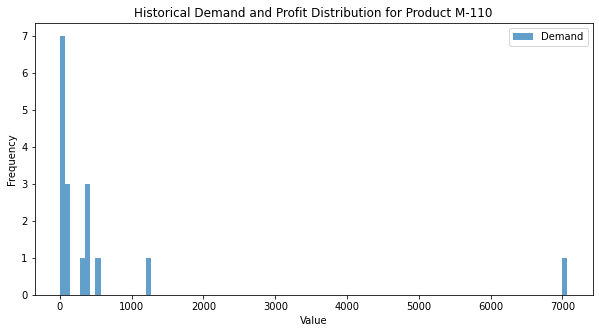

In [116]:
#check individual product distributions
p0156 = month_sales_df[month_sales_df['xitem']=='0156']
plt.figure(figsize=(10, 5))
plt.hist(p0156['xqty'], bins=100, alpha=0.7, label='Demand')
# plt.hist(month_sales_df['Profit'], bins=20, alpha=0.7, label='Profit')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.title(f'Historical Demand and Profit Distribution for Product {product_code}')
plt.show()

In [114]:
demand_mean, demand_std = norm.fit(p0430['xqty'])
print(f'Estimated parameters for demand - Mean: {demand_mean}, Std Dev: {demand_std}')

profit_mean, profit_std = norm.fit(p0430['Profit'])
print(f'Estimated parameters for profit - Mean: {profit_mean}, Std Dev: {profit_std}')

Estimated parameters for demand - Mean: 2154.44, Std Dev: 2504.19168723163
Estimated parameters for profit - Mean: 14760.614611120003, Std Dev: 18645.54308263297


In [115]:
from scipy.stats import kstest

# Test goodness of fit for demand
ks_stat, p_value = kstest(p0430['xqty'], 'norm', args=(demand_mean, demand_std))
print(f'K-S test statistic for demand: {ks_stat}, p-value: {p_value}')

# Interpret the p-value (p > 0.05 means the distribution fits well)
if p_value > 0.05:
    print("The normal distribution is a good fit for demand.")
else:
    print("The normal distribution may not be a good fit for demand.")

K-S test statistic for demand: 0.28637210489545384, p-value: 0.026192282728633942
The normal distribution may not be a good fit for demand.


In [ ]:
    
#     #Profit distribution for all the months for this product within the sales data
#     profit_mean, profit_std = norm.fit(product_data['Profit'])
#     ks_stat_normal_profit, p_value_normal_profit = kstest(product_data['Profit'], 'norm', args=(profit_mean, profit_std))

#     log_shape_profit, log_loc_profit, log_scale_profit = lognorm.fit(product_data['Profit'], floc=0)
#     ks_stat_lognorm_profit, p_value_lognorm_profit = kstest(product_data['Profit'], 'lognorm', args=(log_shape_profit, log_loc_profit, log_scale_profit))

#     if p_value_normal_profit > 0.05:
#         best_fit_profit = 'Normal'
#     elif p_value_lognorm_profit > 0.05:
#         best_fit_profit = 'Lognormal'
#     else:
#         best_fit_profit = 'Empirical'
    
    #Profit ratio probability distribution. 
#     elif demand_dist == 'Lognormal':
#         log_shape, log_loc, log_scale = lognorm.fit(product_data['xqty'], floc=0)
        
#         lower_threshold_demand = np.percentile(product_data['xqty'], 5)
#         upper_threshold_demand = np.percentile(product_data['xqty'], 95) 

#         max_attempts = 100

#         demand_scenarios = []
#         for _ in range(num_scenarios):
#             attempts = 0
#             while attempts < max_attempts:
#                 sampled_value = np.random.lognormal(log_scale, log_shape)
#                 if lower_threshold_demand <= sampled_value <= upper_threshold_demand:
#                     demand_scenarios.append(sampled_value)
#                     break
#                 attempts += 1

#             if attempts == max_attempts:
#                 demand_scenarios.append(upper_threshold_demand)
                
#         demand_probabilities = lognorm.pdf(demand_scenarios, log_shape, log_loc, log_scale)
#         demand_probabilities /= demand_probabilities.sum()
    
    #     elif profit_dist == 'Lognormal':
#         log_shape_profit, log_loc_profit, log_scale_profit = lognorm.fit(product_data['Profit/unit'], floc=0)
#         lower_threshold_profit = np.percentile(product_data['Profit/unit'], 5) 
#         upper_threshold_profit = np.percentile(product_data['Profit/unit'], 95) 
        
#         max_attempts = 100

#         profitr_scenarios = []
#         for _ in range(num_scenarios):
#             attempts = 0
#             while attempts < max_attempts:
#                 sampled_value = np.random.lognormal(log_scale_profit, log_shape_profit)
#                 if lower_threshold_profit <= sampled_value <= upper_threshold_profit:
#                     profitr_scenarios.append(sampled_value)
#                     break
#                 attempts += 1

#             if attempts == max_attempts:
#                 profitr_scenarios.append(upper_threshold_profit)
                
#         profit_probabilities = lognorm.pdf(profitr_scenarios, log_shape_profit, log_loc_profit, log_scale_profit)
#         profit_probabilities /= profit_probabilities.sum() #log normal data is sparse in our case and correct calculation might not be possible